# Analyse der Layer-Anzahl für Multi-layered Perceptrons

In diesem Notebook analysieren wir die Leistung eines Multi-layered Perceptrons (MLP) basierend auf
verschiedenen Größen der Hidden-Layers. Wir erwarten, dass dieser Parameter einen erheblichen
Einfluss auf die Leistungsmetriken des Modell hat.

Als Basis verwenden wir das `sizes`-Array, welches die folgenden Größen annimmt:

$$\{ (1,1),~(1,10),~(1,20),~\ldots,~(1,50),~(10,1),~(10,10),~\ldots,~(10,50),~\ldots,~(50,50)\}$$

Wir kommen zum Schluss, dass die beste Präzision von 55,56% bei einer Größe von $(70,30)$ erreicht
wird. Der F1-Score liegt dabei bei für die Praxis ungenügenden 0,12.

## Feature-Matrix und Label laden

🔗 siehe [mfcc_generate_new_cut.ipynb](mfcc_generate_new_cut.ipynb)

In [1]:
max_file_count = None
none_replacement = 'all'

RANDOM_STATE = 42

In [2]:
import numpy as np
np.set_printoptions(precision=4, suppress=True)

In [3]:
feature_matrix = np.load(f'mfcc_feature_new_cut_{max_file_count or none_replacement}.npy')
labels = np.load(f'labels_new_cut_{max_file_count or none_replacement}.npy')

## Aufteilung in Trainings- und Testdaten

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_matrix, labels,
                                                    test_size=0.2, random_state=RANDOM_STATE)

In [5]:
print(X_train.shape)
print(X_test.shape)

(31697, 44)
(7925, 44)


In [6]:
LABEL_NO_WHISTLE = -1
LABEL_WHISTLE = 1

## Analyse der Layer

In [8]:
# get possible sizes from (1,1) to (50,50) with step length 10
sizes = []
for i in range(0, 100 + 10, 10):
    for j in range(0, 50 + 10, 10):
        sizes.append([max(1, i), max(1, j)])
sizes = np.array(sizes)

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from tqdm import tqdm

accuracies = []
precisions = []
recalls = []
f1s = []

for size in tqdm(sizes, unit='size'):
    model = MLPClassifier(hidden_layer_sizes=size, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    
    y_test_predict = model.predict(X_test)
    
    # proportion of correct predictions
    accuracies.append(metrics.accuracy_score(y_test, y_test_predict))
    
    # proportion of true positives under all positives
    precisions.append(metrics.precision_score(y_test, y_test_predict, zero_division=0))
    
    # proportion of true positives under actually positives
    recalls.append(metrics.recall_score(y_test, y_test_predict))
    
    # total performance
    f1s.append(metrics.f1_score(y_test, y_test_predict))

accuracies = np.array(accuracies)
precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)

100%|██████████| 66/66 [08:01<00:00,  7.30s/size]


In [10]:
size_best_f1 = sizes[np.argmax(f1s)]
size_best_recall = sizes[np.argmax(recalls)]
size_best_precision = sizes[np.argmax(precisions)]

print(f'best f1:        {np.max(f1s):.4f} with size {size_best_f1}')
print(f'best recall:    {np.max(recalls):.4f} with size {size_best_recall}')
print(f'best precision: {np.max(precisions):.4f} with size {size_best_precision}')

best f1:        0.1786 with size [60 50]
best recall:    0.1370 with size [60 50]
best precision: 0.5556 with size [70 30]


In [11]:
print(f'precision at best f1: {precisions[np.argmax(f1s)]:.2f}')
print(f'f1 at best precision: {f1s[np.argmax(precisions)]:.2f}')

precision at best f1: 0.26
f1 at best precision: 0.12


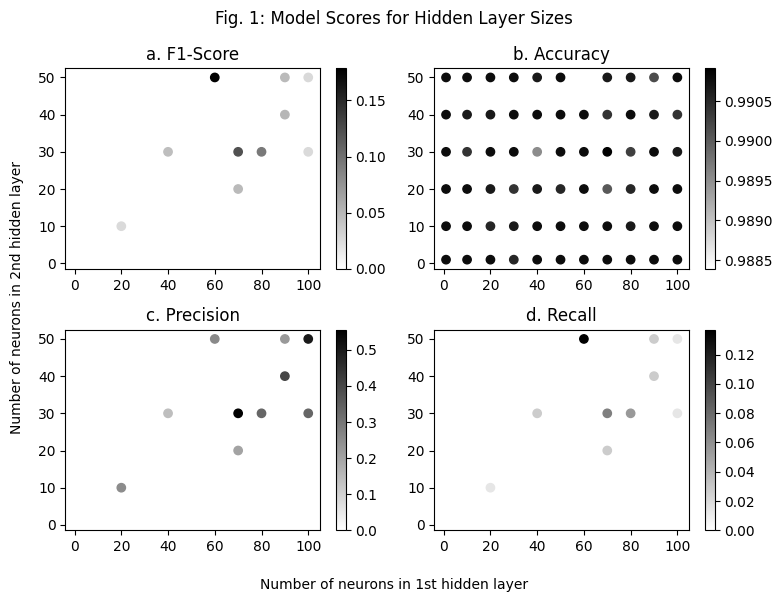

In [86]:
import matplotlib.pyplot as plt
import scipy.interpolate

fig, axs = plt.subplots(2, 2, figsize=(8,6))
cmap = 'binary'

scatter_f1 = axs[0, 0].scatter(sizes[:, 0], sizes[:, 1], c=f1s, cmap=cmap)
fig.colorbar(scatter_f1, ax=axs[0, 0])
axs[0, 0].set_title('a. F1-Score')

scatter_accs = axs[0, 1].scatter(sizes[:, 0], sizes[:, 1], c=accuracies, cmap=cmap)
fig.colorbar(scatter_accs, ax=axs[0, 1])
axs[0, 1].set_title('b. Accuracy')

scatter_precs = axs[1, 0].scatter(sizes[:, 0], sizes[:, 1], c=precisions, cmap=cmap)
fig.colorbar(scatter_precs, ax=axs[1, 0])
axs[1, 0].set_title('c. Precision')

scatter_recs = axs[1, 1].scatter(sizes[:, 0], sizes[:, 1], c=recalls, cmap=cmap)
fig.colorbar(scatter_recs, ax=axs[1, 1])
axs[1, 1].set_title('d. Recall')

fig.suptitle('Fig. 1: Model Scores for Hidden Layer Sizes')
fig.supxlabel('Number of neurons in 1st hidden layer', fontsize=10)
fig.supylabel('Number of neurons in 2nd hidden layer', fontsize=10)

fig.tight_layout()
plt.show()

In Fig. 1 sind die Leistungsmetriken der Modelle basierend auf den verschiedenen Hidden-Layer-Größen
dargestellt. In Subfig. 1a. wird deutlich, dass der F1-Score mit zunehmender Neuronenanzahl in
beiden versteckten Schichten zunimmt. Dieser nimmt allerdings ab dem Bestwert von 0,18 bei $(60,50)$
wieder ab. Dort erreicht der Recall ebenfalls den besten Wert.

Bei der Präzision scheint das Verhalten ähnlich zu sein. Im oberen rechten Quadranten häufen sich
die besseren Werte. Das Optimum liegt mit 55,56% bei $(70,30)$.

Im Real-Szenario sieht es wie folgt aus. Es ist für die Roboter besser, einen tatsächlich
aufgetretenen Pfiff *nicht* zu erkennen, als eine Sekunde, in der kein Pfiff war, als Pfiff zu
klassifizieren. Dementsprechend wollen wir die False-Negatives minimieren. Somit optimieren wir
im folgenden die Präzision anstelle des Recalls.

Daher wird im Folgenden das resultierende Modell mit der Hidden-Layer-Größe von $(70,30)$ trainiert.

## Resultierendes Modell mit bester Performance

In [70]:
print(f'train model with size {size_best_precision}')

# train model
model = MLPClassifier(hidden_layer_sizes=size_best_precision, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

train model with size [70 30]


MLPClassifier(hidden_layer_sizes=array([70, 30]), random_state=42)

In [71]:
import skops.io as sio
sio.dump(model, f'mlp_layer.skops')

In [72]:
# generate predictions for test data
y_test_predict = model.predict(X_test)

In [73]:
print(f'#correct predictions: {y_test[y_test == y_test_predict].shape[0]}')
print(f'#false predictions:   {y_test[y_test != y_test_predict].shape[0]}')

#correct predictions: 7853
#false predictions:   72


In [74]:
print(f'#real whistles:      {y_test[y_test == LABEL_WHISTLE].shape[0]}')
print(f'#predicted whistles: {y_test_predict[y_test == LABEL_WHISTLE].shape[0]}')

#real whistles:      73
#predicted whistles: 73


In [75]:
print(f'#real no whistles:      {y_test[y_test == LABEL_NO_WHISTLE].shape[0]}')
print(f'#predicted no whistles: {y_test_predict[y_test == LABEL_NO_WHISTLE].shape[0]}')

#real no whistles:      7852
#predicted no whistles: 7852


In [76]:
# proportion of correct predictions
print(f'accuracy:  {metrics.accuracy_score(y_test, y_test_predict):.4f}')

# proportion of true positives under all positives
print(f'precision: {metrics.precision_score(y_test, y_test_predict):.4f}')

# proportion of true positives under actually positives
print(f'recall:    {metrics.recall_score(y_test, y_test_predict):.4f}')

# total performance
print(f'f1:        {metrics.f1_score(y_test, y_test_predict):.4f}')

accuracy:  0.9909
precision: 0.5556
recall:    0.0685
f1:        0.1220


In [77]:
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

          -1       0.99      1.00      1.00      7852
           1       0.56      0.07      0.12        73

    accuracy                           0.99      7925
   macro avg       0.77      0.53      0.56      7925
weighted avg       0.99      0.99      0.99      7925



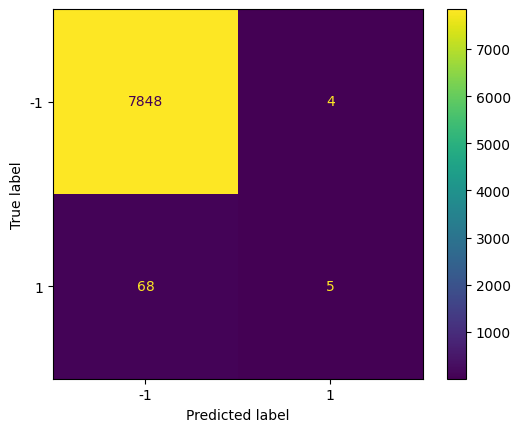

In [78]:
_ = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict)

In [79]:
# relative confusion matrix
print(metrics.confusion_matrix(y_test, y_test_predict) / y_test.shape[0])

[[0.9903 0.0005]
 [0.0086 0.0006]]
